In [ ]:
# run first
import pandas as pd
from nilearn import image, plotting, input_data, glm
#from nilearn.glm import threshold_stats_img
import numpy as np

from nilearn.input_data import NiftiMasker
import nibabel as nib


import os
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
import matplotlib.pyplot as plt
import pdb
from scipy.stats import gamma
import warnings

warnings.filterwarnings('ignore')

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [10]:
# script set up cont'
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import ptoc_params as params

'''exp info'''
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'LO', 'PFS', 'aIPS']
hemispheres = ['left', 'right']
print(subs)

study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
#control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 1 #toolloc_params
vols = 341 #toolloc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

'''run info'''
run_num =2
runs = list(range(1,run_num+1))
run_combos = []

#determine the number of left out run combos
for rn1 in range(1,run_num+1):
    for rn2 in range(rn1+1,run_num+1):
        run_combos.append([rn1,rn2])

['sub-spaceloc1001', 'sub-spaceloc1002', 'sub-spaceloc1003', 'sub-spaceloc1004', 'sub-spaceloc1005', 'sub-spaceloc1006', 'sub-spaceloc1007', 'sub-spaceloc1008', 'sub-spaceloc1009', 'sub-spaceloc1010', 'sub-spaceloc1011', 'sub-spaceloc1012', 'sub-spaceloc2013', 'sub-spaceloc2014', 'sub-spaceloc2015', 'sub-spaceloc2016', 'sub-spaceloc2017', 'sub-spaceloc2018']


Starting second-level analysis...
Processing 18 subjects
ROIs: ['pIPS', 'LO']
Hemispheres: ['right', 'left']
right_pIPS inf
left_pIPS inf
right_LO 2.9338250974184836
left_LO 2.7137753871013475


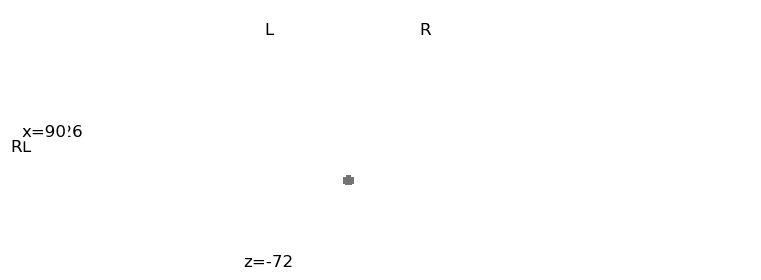

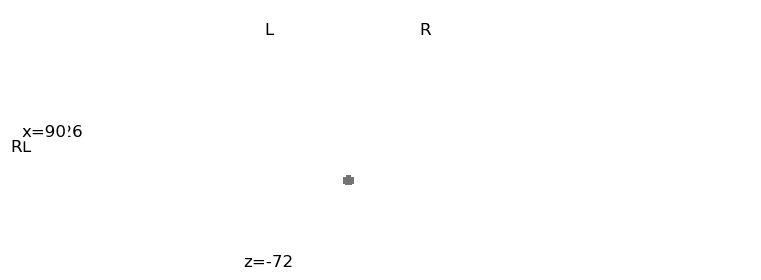

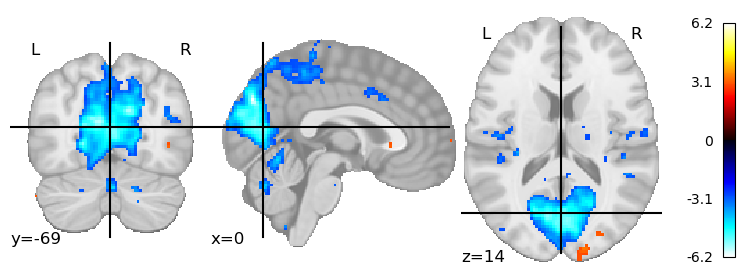

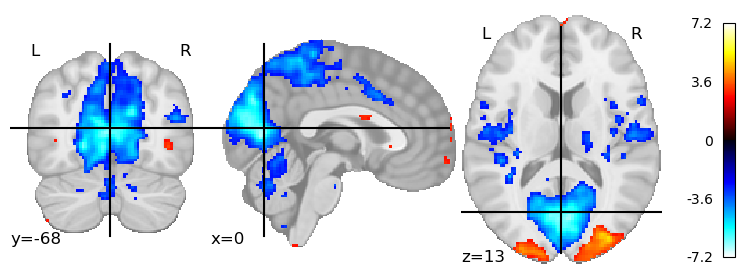

In [13]:
"""
run 2nd level model on each first level
"""
print(f"Starting second-level analysis...")
print(f"Processing {len(subs)} subjects")
print(f"ROIs: {rois}")
print(f"Hemispheres: {hemispheres}")


# Define base directory and parameters
study_dir = '/user_data/csimmon2/temp_derivatives'
alpha = .05
hemispheres = ['right', 'left']
rois = ['pIPS', 'LO']

# Initialize second level model
second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=4)

for roi in rois:
    for hemi in hemispheres:
        ppi_img = []
        for sub in subs:
            # Construct full subject ID
            
            # Build input file path
            input_path = f'{study_dir}/{sub}/ses-01/derivatives/fc/{sub}_{roi}_{hemi}_ToolLoc_ppi_mni.nii.gz'
            
            if os.path.exists(input_path):
                curr_img = image.load_img(input_path)
                curr_img = image.math_img("(img - np.mean(img))/np.std(img)", img=curr_img)
                
                # Save standardized image (keeping same directory structure)
                stand_path = f'{study_dir}/{sub}/ses-01/derivatives/fc/{sub}_{roi}_{hemi}_ToolLoc_ppi_stand.nii.gz'
                nib.save(curr_img, stand_path)
                
                ppi_img.append(curr_img)
            else:
                print(f"Warning: File not found: {input_path}")
        
        if ppi_img:  # Only proceed if we found images
            design_matrix = pd.DataFrame([1] * len(ppi_img),
                                     columns=['intercept'])
            final_img = second_level_model.fit(ppi_img, design_matrix=design_matrix)
            z_map = final_img.compute_contrast(output_type='z_score')

            thresh_val = glm.threshold_stats_img(z_map, alpha=alpha, height_control='fdr', mask_img=whole_brain_mask)
            
            # Save results
            results_path = f'{results_dir}/tools/ppi/{hemi}_{roi}_ppi_stand.nii.gz'
            nib.save(thresh_val[0], results_path)
            print(f'{hemi}_{roi}', thresh_val[1])
            plotting.plot_stat_map(thresh_val[0])

In [14]:
thresh_val[1]

2.7137753871013475

lLO_toolloc
lLO_toolloc


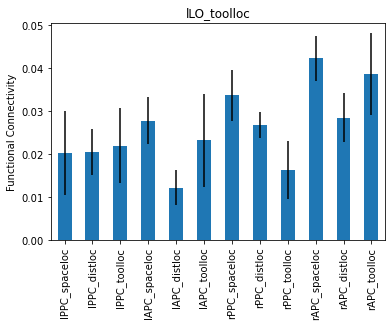

lPFS_toolloc
lPFS_toolloc


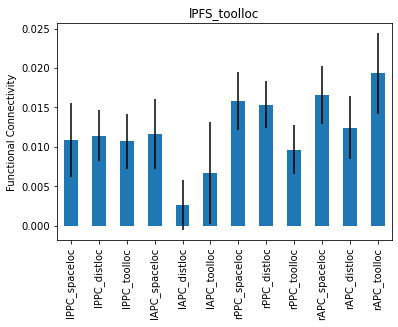

rLO_toolloc
rLO_toolloc


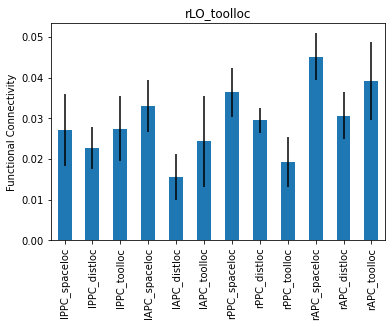

rPFS_toolloc
rPFS_toolloc


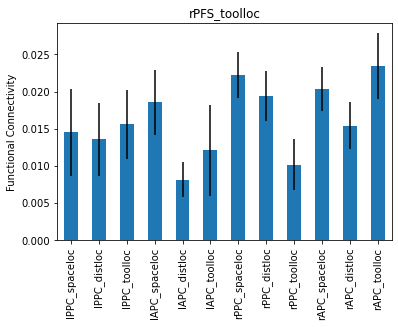

In [4]:
"""
extract avg PPI in LO  and PFS
"""
ventral_rois = ['LO_toolloc']
rois = ["PPC_spaceloc", "PPC_distloc", "APC_spaceloc", "APC_distloc"]

#For each ventral ROI
for lrv in ['l','r']:
    
    for vr in ventral_rois:
        
        summary_df = pd.DataFrame(columns = ['sub'] + ['l' + rr for rr in rois] + ['r' + rr for rr in rois])
        #summary_df = pd.DataFrame(columns = ['sub'] + ['r' + rr for rr in rois])
        ventral = f'{lrv}{vr}'
        print(ventral)
        for ss in subs:
            sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
            roi_dir = f'{sub_dir}/derivatives/rois'
            
            if os.path.exists(f'{roi_dir}/spheres/{ventral}_sphere.nii.gz'):
                ventral_mask = image.load_img(f'{roi_dir}/spheres/{ventral}_sphere.nii.gz')
                ventral_mask = input_data.NiftiMasker(ventral_mask)
                
                
                roi_mean = []
                roi_mean.append(ss)
                #For each dorsal ROI
                for lr in ['l', 'r']:
                    for rr in rois:
                        roi = f'{lr}{rr}'
                        #if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
                        ppi_img = image.load_img(f'{out_dir}/{study}{ss}_{roi}_ppi_stand.nii.gz')
                        #ppi_img  = image.smooth_img(ppi_img, 6)
                        acts = ventral_mask.fit_transform(ppi_img)

                            
                        roi_mean.append(acts.mean())
                        #else:
                        #    roi_mean.append(np.nan)
                
                summary_df = summary_df.append(pd.Series(roi_mean, index = summary_df.columns), ignore_index = True)
        print(ventral)
        summary_df.to_csv(f'{results_dir}/{ventral}_fc.csv', index=False)
        summary_df.iloc[:, 1:].mean().plot(kind = 'bar', title = ventral, ylabel = 'Functional Connectivity',
        yerr=[summary_df.iloc[:,1:].sem().to_list(), summary_df.iloc[:,1:].sem().to_list()])
        plt.pause(0.0001)
                




#                    print(ss, roi)

In [16]:
"""
Compute bootstrap CIs for FC between spaceloc and every roi
"""


ventral_rois = ['LO_toolloc', 'PFS_toolloc']
contrasts = [['rPPC_spaceloc', 'lPPC_toolloc'],['rPPC_spaceloc', 'lAPC_toolloc'], ['rAPC_spaceloc', 'lAPC_toolloc']]
iter = 5000
perm_summary = pd.DataFrame(columns = ['ventral', 'seed1','seed2', 'ci_low', 'ci_high'])
for lr in ['l','r']:
    for vr in ventral_rois:
        df = pd.read_csv(f'{results_dir}/{lr}{vr}_fc.csv')    
        boot_vals = np.zeros((len(contrasts), iter))
        for ii in range(0,iter):
            temp_df = df.sample(len(df), replace = True)
            for cont_n, cont in enumerate(contrasts):
                boot_vals[cont_n, ii] = (temp_df[cont[0]].mean() - temp_df[cont[1]].mean())/ np.mean([np.std(temp_df[cont[0]]),np.std(temp_df[cont[1]])])
                #pdb.set_trace()


        for cont_n, cont in enumerate(contrasts):
            ci_low = np.percentile(boot_vals[cont_n], alpha*100)
            ci_high= np.percentile(boot_vals[cont_n], 100-alpha*100)

            data_row = pd.Series([f'{lr}{vr}', cont[0], cont[1],ci_low, ci_high], index=perm_summary.columns)
            perm_summary = perm_summary.append(data_row,ignore_index=True)

        #pdb.set_trace()

In [15]:
perm_summary

,ventral,seed1,seed2,ci_low,ci_high
0,lLO_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.188267,1.203690
1,lLO_toolloc,rAPC_spaceloc,lAPC_toolloc,0.135171,1.454359
2,lPFS_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.162605,1.208981
3,lPFS_toolloc,rAPC_spaceloc,lAPC_toolloc,0.039543,1.170276
4,rLO_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.201976,1.066534
5,rLO_toolloc,rAPC_spaceloc,lAPC_toolloc,0.198825,1.495103
6,rPFS_toolloc,rPPC_spaceloc,lPPC_toolloc,-0.143206,1.195301
7,rPFS_toolloc,rAPC_spaceloc,lAPC_toolloc,-0.010428,1.157120


In [10]:
summary_df

,sub,rPPC_spaceloc,rPPC_distloc,rPPC_toolloc,rAPC_spaceloc,rAPC_distloc,rAPC_toolloc


In [3]:
ss = 2013
sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
cov_dir = f'{sub_dir}/covs'
roi_dir = f'{sub_dir}/derivatives/rois'
exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

img4d = image.load_img(f'{exp_dir}/run-0{[1,2]}/1stLevel.feat/filtered_func_data_reg.nii.gz')

In [4]:
ims = []
ims.append(image.load_img(f'{exp_dir}/run-0{1}/1stLevel.feat/filtered_func_data_reg.nii.gz'))
ims.append(image.load_img(f'{exp_dir}/run-0{2}/1stLevel.feat/filtered_func_data_reg.nii.gz'))

img4d2 = image.concat_imgs(ims)

In [33]:
type(img4d)

nibabel.nifti1.Nifti1Image

In [13]:
runs = [1]
ss = 1001
#def make_psy_cov(runs,ss):
sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
cov_dir = f'{sub_dir}/covs'
times = np.arange(0, vols*len(runs), tr)
full_cov = pd.DataFrame(columns = ['onset','duration', 'value'])
for rn, run in enumerate(runs):    
    
    curr_cov = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{run}_SA.txt', sep = '\t', header = None, names = ['onset','duration', 'value'])
    #contrasting (neg) cov

    curr_cont = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{run}_FT.txt', sep = '\t', header =None, names =['onset','duration', 'value'])
    curr_cont.iloc[:,2] = curr_cont.iloc[:,2] *-1 #make contrasting cov neg
    
    curr_cov = curr_cov.append(curr_cont) #append to positive

    curr_cov['onset'] = curr_cov['onset'] + (vols*rn)
    full_cov = full_cov.append(curr_cov)
    #add number of vols to the timing cols based on what run you are on
    #e.g., for run 1, add 0, for run 2, add 321
    #curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) 
    #pdb.set_trace()
    
    #append to concatenated cov
full_cov = full_cov.sort_values(by =['onset'])
cov = full_cov.to_numpy()

#convolve to hrf
psy, name = glm.first_level.compute_regressor(cov.T, None, times)
    

    #return psy

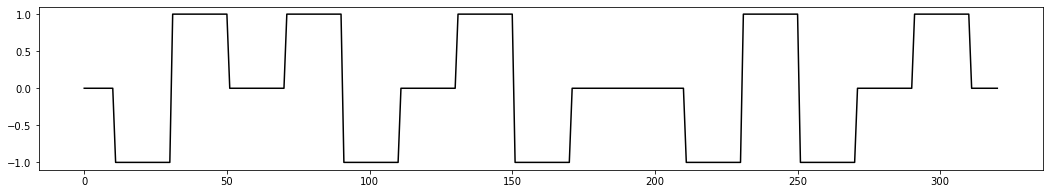

In [22]:
plt.figure(figsize=(18, 3))
plt.plot(psy, color = 'black')
plt.show()



In [23]:
def load_filtered_func(run):
    curr_img = image.load_img(f'{exp_dir}/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz')
    #curr_img = image.clean_img(curr_img,standardize=True, t_r=1)
    
    img4d = image.resample_to_img(curr_img,mni)
    
    roi_masker = input_data.NiftiMasker(roi_mask)
    seed_time_series = roi_masker.fit_transform(img4d)
    
    phys = np.mean(seed_time_series, axis= 1)
    phys = (phys - np.mean(phys)) / np.std(phys)
    phys = phys.reshape((phys.shape[0],1))
    
    return img4d, phys


In [24]:
img4d, phys = load_filtered_func(1)

NameError: name 'roi_mask' is not defined

In [26]:
def make_psy_cov(run):
    times = np.arange(0, vols, tr
                     )
    curr_cov = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{run}_SA.txt', sep = '\t', header = None, names = ['onset','duration', 'value'])
    #contrasting (neg) cov
    curr_cont = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{run}_FT.txt', sep = '\t', header =None, names =['onset','duration', 'value'])
    curr_cont.iloc[:,2] = curr_cont.iloc[:,2] *-1 #make contrasting cov neg
    
    curr_cov = curr_cov.append(curr_cont) #append to positive
    #add number of vols to the timing cols based on what run you are on
    #e.g., for run 1, add 0, for run 2, add 321
    #curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) 
    #pdb.set_trace()
    cov = curr_cov
    #append to concatenated cov
    
    curr_cov = curr_cov.to_numpy()
    
    #convolve to hrf
    psy, name = glm.first_level.compute_regressor(curr_cov.T, 'spm', times)
    
    '''
    #create offsett
    cov['offset'] = cov['onset'] + cov['duration']
    cov[['onset', 'offset']] = np.round(cov[['onset', 'offset']])

    #sort by onset    
    cov = cov.sort_values(by='onset')

    #Convert cov into a continuous predictor with a value for every time point
    psy = np.zeros((vols*rn,2)) #make zero with the length of all runs puttogether
    psy[:,0] = list(range(1,vols*rn+1))

    for ii in cov_ts[:,0]:
        ii =int(ii)
        try:
            psy[ii,1] = cov['value'][(ii >= np.round(cov['onset'])) & (ii < (np.round(cov['offset'])))].to_list()[0]
        except:
            pass
    ''' 
    return psy
    

In [27]:
subs = [2013]
rois = ['PPC_spaceloc']
runs = [1]

for ss in subs:
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
    cov_dir = f'{sub_dir}/covs'
    roi_dir = f'{sub_dir}/derivatives/rois'
    exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'
    for lr in ['r']:
        for rr in rois:
            roi = f'{lr}{rr}'
            if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
                print(ss, roi)

                roi_mask = image.load_img(f'{roi_dir}/{roi}_peak.nii.gz')

                all_runs = []
                for rn in runs:
                    confounds = pd.DataFrame(columns =['psy', 'phys'])
                    #load behavioral data
                    #CONVOLE TO HRF
                    psy = make_psy_cov(rn)

                    #load filtered func data
                    img4d, phys = load_filtered_func(rn)

                    #combine phys (seed TS) and psy (task TS) into a regressor
                    confounds['psy'] = psy[:,0]
                    confounds['phys'] =phys[:,0]

                    #create PPI cov by multiply psy * phys
                    ppi = psy*phys
                    ppi = ppi.reshape((ppi.shape[0],1))

                    # extract data from whole brain mask
                    #regress seed phys and psy leaving only residuals

                    brain_time_series = brain_masker.fit_transform(img4d, confounds=[confounds])

                    #Correlate interaction term to TS for vox in the brain
                    seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                                      ppi.shape[0])
                    
                    seed_to_voxel_correlations = np.arctanh(seed_to_voxel_correlations)
                    #transform correlation map back to brain
                    seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)
                    
                    all_runs.append(seed_to_voxel_correlations_img)

                mean_fc = image.mean_img(all_runs)
                
                #nib.save(mean_fc, f'{out_dir}/sub-{study}{ss}_{roi}_fc.nii.gz')

        #Extract timeseries from top voxels of roi

        #create interaction term



2013 rPPC_spaceloc


In [ ]:
"""
create average
"""

for lr in ['r']:
    for rr in rois:
        roi = f'{lr}{rr}'
        print(roi)
        mean_ppi = []
        for ss in subs:
            sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
            roi_dir = f'{sub_dir}/derivatives/rois'
            
            if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
                ppi_img = image.load_img(f'{out_dir}/sub-{study}{ss}_{roi}_fc.nii.gz') #load image
                affine = ppi_img.affine #get affine transforms
                #ppi_img = np.arctanh(image.get_data(ppi_img))  #get image and fisher z it
                
                #ppi_img= (ppi_img-np.mean(ppi_img))/np.std(ppi_img)
                
                mean_ppi.append(ppi_img) #convert back to nifti
                
            
        mean_ppi=image.mean_img(mean_ppi)
        mean_ppi = image.math_img("(img - np.mean(img))/np.std(img)", img=mean_ppi)
        #find fdr-corrected threshold
        thresh_val = glm.threshold_stats_img(mean_ppi,alpha=.05,  height_control='fdr', cluster_threshold = 5, two_sided = False)
        thresh_img = image.threshold_img(mean_ppi, thresh_val[1])
        plotting.plot_glass_brain(thresh_img,  draw_cross = False,threshold = 3.1, colorbar = True)
        plt.pause(0.0001)
                
                
                
                
                
                
                
                

In [ ]:
mean_ppi

In [ ]:
ss = 1001
roi = 'rPPC_spaceloc'
rn = 1
roi_mask = image.load_img(f'{roi_dir}/{roi}_peak.nii.gz')
psy = make_psy_cov(rn)
img4d, phys = load_filtered_func(rn)


In [ ]:
curr_cov = curr_cov.iloc[:,0:3]
curr_cov = curr_cov.to_numpy()
            
psy, name = glm.first_level.compute_regressor(curr_cov.T, 'spm', times)

In [ ]:
phys_z = (phys - np.mean(phys)) / np.std(phys)

plt.plot(phys_z)
plt.plot(psy)
plt.plot(ppi)
ppi = psy*phys_z


In [ ]:
plt.plot(ppi)
plt.plot(psy)

In [ ]:
#pad = np.zeros((int(4/tr),2))
#psy = np.vstack([pad, psy])
#psy = psy[:vols, 1]
#ppi = psy
brain_time_series = brain_masker.fit_transform(img4d)

#Correlate interaction term to TS for vox in the brain
seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                  ppi.shape[0])

#transform correlation map back to brain
seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)
print(seed_to_voxel_correlations.shape)
print(seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max())

In [ ]:
cov

In [ ]:

plotting.view_img(seed_to_voxel_correlations_img, threshold = .1)

In [ ]:
psy


In [ ]:
psy.shape

In [ ]:
"""
Create behavioral covariate
with contrasting 1/-1 conditions
"""


#runs = [1]
#Load covs for each run
for rn_n,rn in enumerate(runs):
    print(rn)
    #postive cov
    curr_cov = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{rn}_SA.txt', sep = '\t', header = None, names = ['onset','duration', 'value'])
    #contrasting (neg) cov
    curr_cont = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{rn}_FT.txt', sep = '\t', header =None, names =['onset','duration', 'value'])
    curr_cont.iloc[:,2] = curr_cont.iloc[:,2] *-1 #make contrasting cov neg
    
    curr_cov = curr_cov.append(curr_cont) #append to positive
    #add number of vols to the timing cols based on what run you are on
    #e.g., for run 1, add 0, for run 2, add 321
    curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) 
    #pdb.set_trace()
    
    #append to concatenated cov
    if rn_n ==0 :
        cov = curr_cov
    else:
        cov = cov.append(curr_cov)

#create offsett
cov['offset'] = cov['onset'] + cov['duration']
cov[['onset', 'offset']] = np.round(cov[['onset', 'offset']])
    
#sort by onset    
cov = cov.sort_values(by='onset')

#Convert cov into a continuous predictor with a value for every time point
psy = np.zeros((vols*rn,2)) #make zero with the length of all runs puttogether
psy[:,0] = list(range(1,vols*rn+1))

for ii in cov_ts[:,0]:
    ii =int(ii)
    try:
        psy[ii,1] = cov['value'][(ii >= np.round(cov['onset'])) & (ii < (np.round(cov['offset'])))].to_list()[0]
    except:
        pass

In [ ]:
"""
load filtered func data from all runs
"""
runs = [1]
all_nii = []
for rn in runs:
    print(rn)
    curr_img = image.load_img(f'{exp_dir}/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz')
    curr_img = image.clean_img(curr_img,standardize=True, t_r=1)
    all_nii.append(curr_img)

#img4d = image.concat_imgs(all_nii) #compile into 4D

img4d = image.resample_to_img(curr_img,mni)


#run_img = load_img(f'{exp_dir}/run-01/1stLevel.feat/filtered_func_data.nii.gz')

In [ ]:

roi_data = pd.read_csv(f'{roi_dir}/data/{rr}.txt',  sep="  ", header = None, names = ['x','y', 'z', 'value'])
roi_data = roi_data.sort_values(by = 'value',ascending = False).reset_index()
roi_mask = image.load_img(f'{roi_dir}/{rr}_peak.nii.gz')

In [ ]:
first_vol = image.index_img(curr_img,0)
plotting.plot_stat_map(first_vol, threshold = 1)

In [ ]:
plotting.plot_roi(roi_mask, bg_img = mni)

In [ ]:
roi_masker = input_data.NiftiMasker(roi_mask)
seed_time_series = roi_masker.fit_transform(img4d)

In [ ]:
phys = np.mean(seed_time_series, axis= 1)
phys = avg_ts.reshape((phys.shape[0],1))



In [ ]:
HRF_COV = hrf(psy[:,1], 1)
plt.plot(HRF_COV)
psy.shape

In [ ]:
times = np.arange(0, vols, 1)
test = cov.iloc[:,:3].to_numpy()

signal, name = glm.first_level.compute_regressor(test.T, 'spm', times)


In [ ]:
plt.plot(signal)
len(signal)

In [ ]:
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

In [ ]:
exp_condition

In [ ]:
seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                              avg_ts.shape[0]
                              )
print(seed_to_voxel_correlations.shape)
print(seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max())

In [ ]:
from nilearn import plotting

seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.1, vmax=1,
                                 cut_coords=roi_coords[0],
                                 title="Seed-to-voxel correlation"
                                 )
#display.add_markers(marker_coords=roi_coords, marker_color='g',
#                    marker_size=300)

In [ ]:
test = []
test.append(seed_to_voxel_correlations_img)
test.append(seed_to_voxel_correlations_img)

In [ ]:
test_mean = image.mean_img(test)
test_mean.shape

In [ ]:
plotting.view_img(seed_to_voxel_correlations_img, threshold = .1)

In [ ]:
roi_mask = image.load_img(f'{roi_dir}/rPPC_spaceloc.nii.gz')
plotting.plot_roi(roi_mask, bg_img = seed_to_voxel_correlations_img)

In [ ]:
from nilearn import datasets

dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]
confound_filename = dataset.confounds[0]

In [ ]:
confounds = pd.read_csv(confound_filename, sep = '\t')

In [ ]:
confounds

In [ ]:
"""
Extract timeseries from peak voxel of ROI
"""


roi_coords = [tuple(roi_data[['x','y','z']].iloc[0].to_list())]

seed_masker = input_data.NiftiSpheresMasker(
    roi_coords, radius=8)

seed_time_series = seed_masker.fit_transform(img4d)
brain_time_series = brain_masker.fit_transform(img4d)

In [ ]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])